# Lab 06: Técnicas de Optimización de Entrenamientos

En este laboratorio, vamos a explorar algunas técnicas de optimización de entrenamientos de redes neuronales. En particular, vamos a explorar cómo optimizar los modelos de Deep Learning para mejorar su rendimiento. Primero recordamos cómo se evalúan los modelos a través del sesgo y la varianza, por qué hay que encontrar un equilibrio entre ellos y cuáles son las diferentes estrategias para reducirlos. Antes de conocer estas estrategias comprendemos lo que son los hiperparámetros y cuáles componen los modelos de redes neuronales. Por último, estudiamos qué hiperparámetros escoger para optimizar el rendimiento de los modelos, desde los más básicos hasta los más avanzados.

## 0. Librerías

In [71]:
!pip install -q opendatasets
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install spacy
!pip install nltk
!pip install wordcloud
!pip install gensim
!pip install scikit-learn
!pip install tensorflow
!pip install keras
!python -m spacy download en_core_web_sm


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 

In [2]:
import os
import random
import time
import opendatasets as od
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import spacy 
import nltk
from nltk.corpus import stopwords
import re
import gensim.downloader
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad

# Fijar la semilla aleatoria para reproducibilidad
seed_value = 42
tf.random.set_seed(seed_value)  # Semilla de TensorFlow
np.random.seed(seed_value)  # Semilla de NumPy
random.seed(seed_value)  # Semilla de Python
os.environ['PYTHONHASHSEED'] = str(seed_value)  # Semilla para hash de Python para reproducibilidad

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/alejandro.gouloumis/miniconda3/envs/bootcamp_nlp/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024-05-27 15:52:01.894973: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 15:52:02.699344: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alejandro.gouloumis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alejandro.gouloumis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]    

## 1. Carga de datos

In [44]:
# Definimos los nombres de las columnas
columns=['id','category','label','text']

# Descargarmos los datasets y los leemos
od.download('https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis') # inserta tu usuario y key de kaggle
df_train = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_training.csv', names=columns)
df_test = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_validation.csv', names=columns)

df_train.head()

Skipping, found downloaded files in "./twitter-entity-sentiment-analysis" (use force=True to force download)


,id,category,label,text
0,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
1,2401,Borderlands,Positive,"I am coming to the borders and I will kill you all,"
2,2401,Borderlands,Positive,"im getting on borderlands and i will kill you all,"
3,2401,Borderlands,Positive,"im coming on borderlands and i will murder you all,"
4,2401,Borderlands,Positive,"im getting on borderlands 2 and i will murder you me all,"


## 2. Preprocesamiento de datos

In [3]:
def limpiar_tweet(tweet):
    # Convertir a string
    tweet = str(tweet)

    # Eliminar URLs
    tweet = re.sub(r'http\S+', '', tweet)

    # Eliminar menciones y hashtags
    tweet = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', tweet)

    # Eliminar caracteres especiales, números, and signos de puntuación
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)

    # Eliminar indicador de 'RT' (Retweet)
    tweet = re.sub(r'\bRT\b', '', tweet)

    # Reemplazamos contracciones
    tweet = re.sub(r"won\'t", "would not", tweet)
    tweet = re.sub(r"im", "i am", tweet)
    tweet = re.sub(r"Im", "I am", tweet)
    tweet = re.sub(r"can\'t", "can not", tweet)
    tweet = re.sub(r"don\'t", "do not", tweet)
    tweet = re.sub(r"shouldn\'t", "should not", tweet)
    tweet = re.sub(r"needn\'t", "need not", tweet)
    tweet = re.sub(r"hasn\'t", "has not", tweet)
    tweet = re.sub(r"haven\'t", "have not", tweet)
    tweet = re.sub(r"weren\'t", "were not", tweet)
    tweet = re.sub(r"mightn\'t", "might not", tweet)
    tweet = re.sub(r"didn\'t", "did not", tweet)
    tweet = re.sub(r"n\'t", " not", tweet)
    tweet = re.sub(r"\'re", " are", tweet)
    tweet = re.sub(r"\'s", " is", tweet)
    tweet = re.sub(r"\'d", " would", tweet)
    tweet = re.sub(r"\'ll", " will", tweet)
    tweet = re.sub(r"\'t", " not",tweet)
    tweet = re.sub(r"\'ve", " have", tweet)
    tweet = re.sub(r"\'m", " am", tweet)

    # Eliminar caracteres especiales
    tweet = re.sub(r'[!]+' , '!' , tweet)
    tweet = re.sub(r'[?]+' , '?' , tweet)
    tweet = re.sub(r'[.]+' , '.' , tweet)
    tweet = re.sub(r'[@]+' , '@' , tweet)
    tweet = re.sub(r'unk' , ' ' , tweet)
    tweet = re.sub('\n', '', tweet)

    # Convertir a minúsculas y eliminar espacios extra
    tweet = tweet.lower()
    tweet = re.sub(r'[ ]+' , ' ' , tweet)

    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    tweet_tokens = nltk.word_tokenize(tweet)
    tweet = ' '.join([word for word in tweet_tokens if word not in stop_words])

    # Lematización
    doc = nlp(tweet)
    # Lematizar cada token y juntarlos de nuevo en un string
    tweet = ' '.join([token.lemma_ for token in doc])

    return tweet

In [4]:
# Aplicamos el preprocesamiento a los tweets
df_train['text_clean'] = df_train['text'].apply(limpiar_tweet)
df_test['text_clean'] = df_test['text'].apply(limpiar_tweet)

In [5]:
# Guardar a .csv para evitar repetir el preprocesamiento
df_train.to_csv('df_train_clean.csv', index=False)
df_test.to_csv('df_test_clean.csv', index=False)

In [6]:
# Leer los datasets limpios
df_train = pd.read_csv('df_train_clean.csv')
df_test = pd.read_csv('df_test_clean.csv')

In [7]:
# Mostrar el número de filas con valores nulos en las columnas 'label' o 'text'
print('Filas con valores nulos en el dataset de entrenamiento:')
print(df_train[['label','text_clean']].isnull().sum())
print('\nFilas con valores nulos en el dataset de validación:')
print(df_test[['label','text_clean']].isnull().sum())

# Eliminar filas con valores nulos
df_train = df_train.dropna(subset=['label','text_clean'])
df_test = df_test.dropna(subset=['label','text_clean'])

Filas con valores nulos en el dataset de entrenamiento:
label            0
text_clean    2605
dtype: int64

Filas con valores nulos en el dataset de validación:
label         0
text_clean    1
dtype: int64


## 3. Preparamos el entrenamiento

In [8]:
# Descargamos los embeddings preentrenados de dimensión 100 "glove-twitter-100"
glove_vectors = gensim.downloader.load('glove-twitter-100')

In [9]:
# Filtrar el dataset para que solo contenga las clases 'Positive' y 'Negative'
df_train = df_train[df_train['label'].isin(['Positive', 'Negative'])]

# Mapear las etiquetas a valores numéricos
df_train['label'] = df_train['label'].map({'Positive': 1, 'Negative': 0})  # Binary encoding

# Asignamos la variable a predecir 'label' como 'y'
y = df_train['label'].values  # Ensure y is a numpy array of numerical type

In [10]:
# Tokenizamos los textos y los convertimos a secuencias (asignamos X)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text_clean'].values)
sequences = tokenizer.texts_to_sequences(df_train['text_clean'].values)
X = pad_sequences(sequences, maxlen=100)

# Dividir en train y validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Preprocessed text:', df_train['text_clean'].values[100])
print('\nTokenized text:', sequences[100])
print('\nPadded text:', X[100])
print('\nPadded text Length: ', len(X[100]))

Preprocessed text: ok loving also playing bombs earth anything gets hype good rpg concept

Tokenized text: [357, 618, 59, 20, 3230, 1968, 239, 325, 1083, 7, 1675, 1489]

Padded text: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  357  618   59   20 3230 1968  239  325 1083    7
 1675 1489]

Padded text Length:  100


In [11]:
# Preparar la matriz de embeddings
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.key_to_index:  # Updated to use .key_to_index
        embedding_matrix[i] = glove_vectors.get_vector(word)

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.26710999,  0.30684999,  0.28764999, ...,  0.47332999,
        -0.36074999, -0.17855   ],
       [-0.21063   , -0.010992  , -0.17552   , ..., -0.37547001,
         0.58029002,  0.16067   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.099461  , -0.43794999,  0.053826  , ...,  0.45978999,
        -0.12055   , -0.16209   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [41]:
embedding_matrix.shape

(21224, 100)

## 4. Entrenamiento del modelo (FFNN)

Usaremos una red neuronal feedforward con una capa oculta para clasificar el sentimiento de tweets. Comenzamos con una red neuronal simple y luego la optimizaremos poco a poco.

Parámetros vs hiperparámetros:
- **Parámetros**: Son los valores que se aprenden durante el entrenamiento de un modelo. Por ejemplo, los pesos de una red neuronal.
- **Hiperparámetros**: Son los valores que se establecen antes de entrenar un modelo. Por ejemplo, el número de capas ocultas en una red neuronal.

**Hiperparámetros**:
- Número de capas ocultas.
- Número de neuronas por capa.
- Tasa de aprendizaje.
- Número de épocas.
- Batch size.
- ...

### 4.1 Hiperparámetros básicos

In [12]:
# Definir el modelo
model_ffnn = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=False),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Printear la arquitectura del modelo
model_ffnn.summary()

2024-05-27 15:54:13.003625: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,122,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,400 (8.10 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,122,400 (8.10 MB)

In [13]:
# Compilar el modelo
model_ffnn.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Ejemplo de entrenamiento del modelo y guardado del historial utilizando conjuntos de entrenamiento y validación explícitos
history_ffnn = model_ffnn.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7126 - loss: 0.5929 - val_accuracy: 0.7791 - val_loss: 0.5007
Epoch 2/25
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7917 - loss: 0.4775 - val_accuracy: 0.7908 - val_loss: 0.4788
Epoch 3/25
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8013 - loss: 0.4561 - val_accuracy: 0.7932 - val_loss: 0.4705
Epoch 4/25
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8063 - loss: 0.4450 - val_accuracy: 0.7957 - val_loss: 0.4660
Epoch 5/25
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8084 - loss: 0.4375 - val_accuracy: 0.7971 - val_loss: 0.4633
Epoch 6/25
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8109 - loss: 0.4320 - val_accuracy: 0.7982 - val_loss: 0.4614
Epoch 7/25
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8141 - loss: 0.4277 - val_accuracy: 0.7995 - val_loss: 0.4602
Epoch 8/25
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8158 - loss: 0.4242 - 

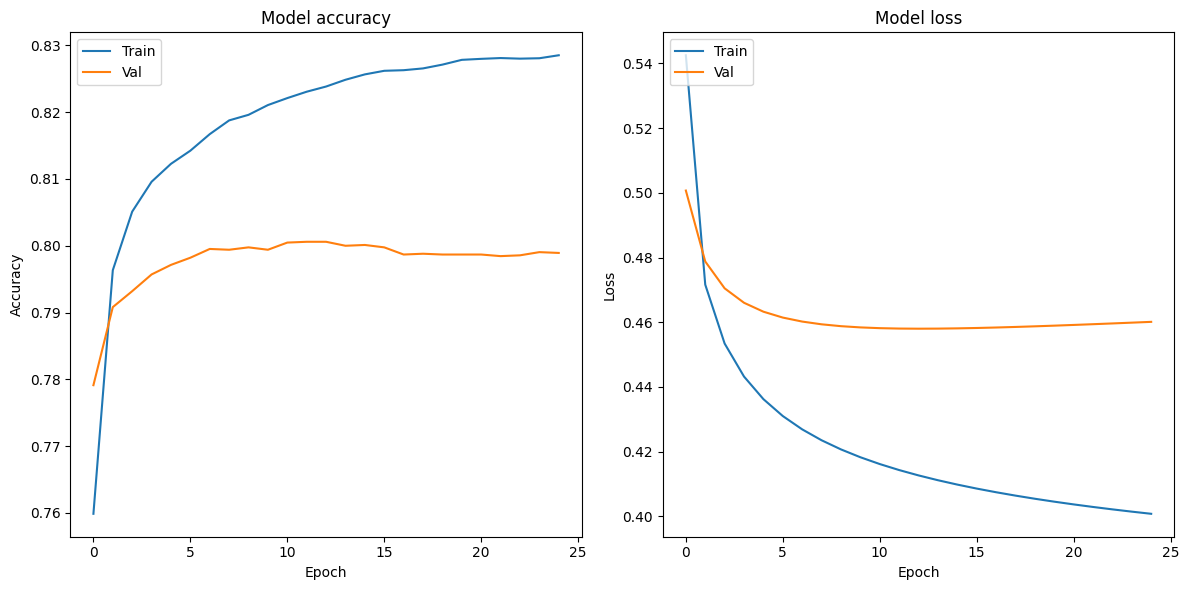

In [14]:
# Assuming 'history' is the result of fitting your model
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_ffnn.history['accuracy'])
plt.plot(history_ffnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_ffnn.history['loss'])
plt.plot(history_ffnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

Como se puede observar, el modelo no es capaz de aprender correctamente. Se produce un sobreajuste o **overfitting**. Esto significa que el modelo se ajusta demasiado a los datos de entrenamiento y no es capaz de generalizar bien a datos nuevos.

Recordamos también el equilibro entre **sesgo** y **varianza**:
- **Sesgo**: Error debido a suposiciones incorrectas en el modelo. Se produce **underfitting**.
- **Varianza**: Error debido a la sensibilidad del modelo a pequeñas variaciones en los datos de entrenamiento. Se produce **overfitting**.

Un sesgo alto y una varianza baja producen **underfitting**.
Un sesgo bajo y una varianza alta producen **overfitting**.

### 4.2 Batch size

El tamaño del batch es un hiperparámetro que determina cuántas muestras se van a utilizar para calcular el gradiente en cada iteración. Un tamaño de batch pequeño puede hacer que el entrenamiento sea más lento, pero también puede hacer que el modelo sea más preciso. Por otro lado, un tamaño de batch grande puede hacer que el entrenamiento sea más rápido, pero también puede hacer que el modelo sea menos preciso. Por lo tanto, es importante encontrar un equilibrio entre el tamaño del batch y la precisión del modelo.

In [15]:
# Definir el modelo
model_ffnn_batch = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=False),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Printear la arquitectura del modelo
model_ffnn_batch.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     2,122,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,400 (8.10 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,122,400 (8.10 MB)

In [16]:
# Compilar el modelo
model_ffnn_batch.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Ejemplo de entrenamiento del modelo y guardado del historial
start_time = time.time()
history_ffnn_batch_64 = model_ffnn_batch.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_val, y_val), verbose=0)
end_time = time.time()
duration = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento con batch 64: {round(duration,2)} segundos")

start_time = time.time()
history_ffnn_batch_128 = model_ffnn_batch.fit(X_train, y_train, epochs=25, batch_size=128, validation_data=(X_val, y_val), verbose=0)
end_time = time.time()
duration = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento con batch 128: {round(duration,2)} segundos")

start_time = time.time()
history_ffnn_batch_256 = model_ffnn_batch.fit(X_train, y_train, epochs=25, batch_size=256, validation_data=(X_val, y_val), verbose=0)
end_time = time.time()
duration = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento con batch 256: {round(duration,2)} segundos")

start_time = time.time()
history_ffnn_batch_512 = model_ffnn_batch.fit(X_train, y_train, epochs=25, batch_size=512, validation_data=(X_val, y_val), verbose=0)
end_time = time.time()
duration = end_time - start_time
print(f"Tiempo de ejecución del entrenamiento con batch 512: {round(duration,2)} segundos")

Tiempo de ejecución del entrenamiento con batch 64: 27.95 segundos
Tiempo de ejecución del entrenamiento con batch 128: 18.99 segundos
Tiempo de ejecución del entrenamiento con batch 256: 18.16 segundos
Tiempo de ejecución del entrenamiento con batch 512: 15.55 segundos


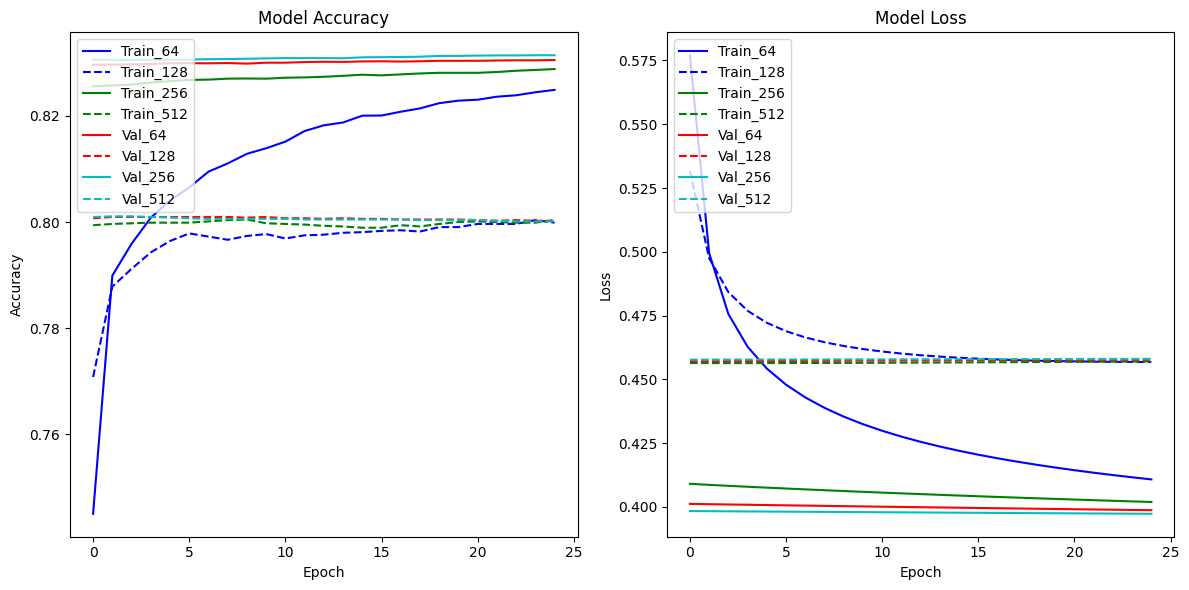

In [17]:
# Colores distintivos para cada grupo de tamaño de lote
colors = ['b', 'g', 'r', 'c']
labels = ['64', '128', '256', '512']

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
for i, history in enumerate([history_ffnn_batch_64.history, history_ffnn_batch_128.history, history_ffnn_batch_256.history, history_ffnn_batch_512.history]):
    plt.plot(history['accuracy'], color=colors[i], linestyle='-')
    plt.plot(history['val_accuracy'], color=colors[i], linestyle='--')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend([f'Train_{l}' for l in labels] + [f'Val_{l}' for l in labels], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
for i, history in enumerate([history_ffnn_batch_64.history, history_ffnn_batch_128.history, history_ffnn_batch_256.history, history_ffnn_batch_512.history]):
    plt.plot(history['loss'], color=colors[i], linestyle='-')
    plt.plot(history['val_loss'], color=colors[i], linestyle='--')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend([f'Train_{l}' for l in labels] + [f'Val_{l}' for l in labels], loc='upper left')

plt.tight_layout()
plt.show()

Para elegir el tamaño del batch debemos considerar lo siguiente:

- Pequeño a Mediano (1-32): Tamaños de lote pequeños pueden proporcionar una actualización de los pesos más frecuente, lo que puede llevar a una convergencia más rápida. Sin embargo, también pueden hacer que el entrenamiento sea más ruidoso, potencialmente llevando a una convergencia a mínimos locales.

- Mediano (32-256): Este rango es comúnmente utilizado ya que ofrece un buen equilibrio entre la eficiencia computacional y la capacidad de generalización. Los tamaños de lote en este rango pueden aprovechar eficientemente las capacidades de hardware modernas (como GPUs), al tiempo que mantienen el ruido en el entrenamiento a un nivel que puede ser beneficioso para escapar de mínimos locales.

- Grande (256-1024+): Los tamaños de lote grandes pueden mejorar la eficiencia computacional al reducir el número de actualizaciones de pesos y aprovechar al máximo el paralelismo en hardware moderno. Sin embargo, pueden requerir ajustes en la tasa de aprendizaje y son más propensos a converger a mínimos locales subóptimos.

Para un conjunto de datos de clasificación de texto, comenzaría con un tamaño de lote en el rango medio (por ejemplo, 64 o 128) y luego ajustaría según sea necesario basado en la capacidad de tu hardware y los resultados de entrenamiento iniciales. Monitorea tanto la pérdida de entrenamiento como la de validación para determinar si necesitas ajustar el tamaño del lote hacia arriba o hacia abajo para mejorar el rendimiento del modelo.

### 4.3 Initialization

Consiste en inicializar los pesos de la red neuronal. Beneficios:
- Convergencia más rápida durante el entrenamiento
- Mejora la capacidad del modelo para alcanzar un mínimo global en la función de pérdida
- Ayuda a mantener la varianza de las activaciones a través de las capas

GlorotUniform es preferible cuando la función de activación de la capa no es una ReLU (o variantes de ReLU), como en este caso donde se utiliza sigmoid. 

La inicialización Xavier/Glorot está diseñada para mantener la varianza de las activaciones a lo largo de las capas, lo que puede ayudar a evitar los problemas de gradientes que desaparecen o explotan en redes profundas.

In [18]:
# Definir el modelo con inicialización especificada en la capa Dense
model_ffnn_initialization = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=False),
    Flatten(),
    Dense(1, activation='sigmoid', kernel_initializer=GlorotUniform())  # Usar Xavier/Glorot como inicializador
])

# Printear la arquitectura del modelo
model_ffnn_initialization.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     2,122,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,400 (8.10 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,122,400 (8.10 MB)

In [19]:
# Compilar el modelo
model_ffnn_initialization.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Ejemplo de entrenamiento del modelo y guardado del historial
history_ffnn_initialization = model_ffnn_initialization.fit(X_train, y_train, epochs=25, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6552 - loss: 0.6480 - val_accuracy: 0.7463 - val_loss: 0.5754
Epoch 2/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7746 - loss: 0.5491 - val_accuracy: 0.7772 - val_loss: 0.5285
Epoch 3/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7850 - loss: 0.5122 - val_accuracy: 0.7832 - val_loss: 0.5081
Epoch 4/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7899 - loss: 0.4928 - val_accuracy: 0.7864 - val_loss: 0.4962
Epoch 5/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7939 - loss: 0.4805 - val_accuracy: 0.7911 - val_loss: 0.4884
Epoch 6/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7961 - loss: 0.4719 - val_accuracy: 0.7914 - val_loss: 0.4829
Epoch 7/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7970 - loss: 0.4653 - val_accuracy: 0.7928 - val_loss: 0.4788
Epoch 8/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7989 - loss: 0.4600 - val_accuracy: 0.

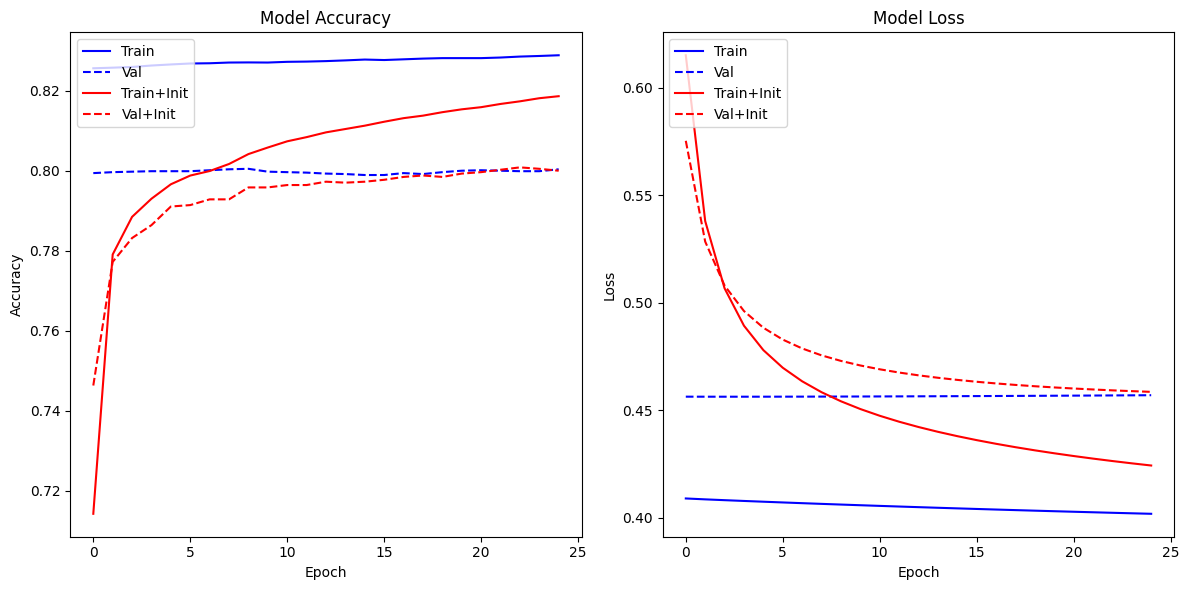

In [20]:
import matplotlib.pyplot as plt

# Asumiendo que 'history_ffnn_batch_128.history' y 'history_ffnn_initialization.history'
# son los resultados de ajustar tu modelo

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = ['b', 'r']  # Colores para grupos
labels = ['Train', 'Val', 'Train+Init', 'Val+Init']
for i, history in enumerate([history_ffnn_batch_128.history, history_ffnn_initialization.history]):
    plt.plot(history['accuracy'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_accuracy'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
for i, history in enumerate([history_ffnn_batch_128.history, history_ffnn_initialization.history]):
    plt.plot(history['loss'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_loss'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### 4.4 Regularización

Los métodos de regularización son técnicas utilizadas en el entrenamiento de modelos de aprendizaje automático para prevenir el sobreajuste, es decir, cuando el modelo aprende patrones específicos del conjunto de datos de entrenamiento tan bien que falla al generalizar a datos no vistos. 

El sobreajuste suele ocurrir en modelos con una gran cantidad de parámetros y/o cuando el conjunto de entrenamiento es relativamente pequeño. Los métodos de regularización ayudan a mejorar la capacidad de generalización del modelo al restringir su complejidad o penalizar los pesos grandes. 

#### 4.4.1 Batch normalization

La normalización por lotes (Batch Normalization) es una técnica para mejorar la estabilidad y el rendimiento del entrenamiento de redes neuronales. Fue introducida por Sergey Ioffe y Christian Szegedy en 2015. La idea detrás de la normalización por lotes es abordar el problema del cambio de distribución interna (Internal Covariate Shift) que ocurre durante el entrenamiento de redes profundas, donde las distribuciones de las entradas de las capas se van desplazando, dificultando el entrenamiento eficiente.

Añadimos una capa de BatchNormalization después de cada capa oculta y antes de la función de activación. La normalización por lotes se realiza por lotes, es decir, para cada mini-lote de datos de entrada, se calcula la media y la varianza de cada característica y se normaliza la característica restando la media y dividiendo por la desviación estándar. La normalización por lotes también incluye dos parámetros adicionales, gamma y beta, que se utilizan para escalar y desplazar la salida de la normalización por lotes, respectivamente.

In [21]:
# Definir el modelo con inicialización especificada en la capa Dense y agregar normalización por lotes
model_ffnn_batchNorm = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=False),
    Flatten(),
    BatchNormalization(),  # Añadir normalización por lotes aquí
    Dense(1, activation='sigmoid')
])

# Printear la arquitectura del modelo
model_ffnn_batchNorm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     2,122,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,400 (8.10 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,122,400 (8.10 MB)

In [22]:
# Compilar el modelo
model_ffnn_batchNorm.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Ejemplo de entrenamiento del modelo y guardado del historial
history_ffnn_batchNorm = model_ffnn_batchNorm.fit(X_train, y_train, epochs=25, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6957 - loss: 0.5977 - val_accuracy: 0.7897 - val_loss: 0.4912
Epoch 2/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7989 - loss: 0.4572 - val_accuracy: 0.7959 - val_loss: 0.4706
Epoch 3/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8106 - loss: 0.4334 - val_accuracy: 0.8005 - val_loss: 0.4678
Epoch 4/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8180 - loss: 0.4208 - val_accuracy: 0.8000 - val_loss: 0.4665
Epoch 5/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8211 - loss: 0.4127 - val_accuracy: 0.7999 - val_loss: 0.4663
Epoch 6/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8232 - loss: 0.4070 - val_accuracy: 0.7995 - val_loss: 0.4668
Epoch 7/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8261 - loss: 0.4027 - val_accuracy: 0.7983 - val_loss: 0.4676
Epoch 8/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8282 - loss: 0.3993 - val_accuracy:

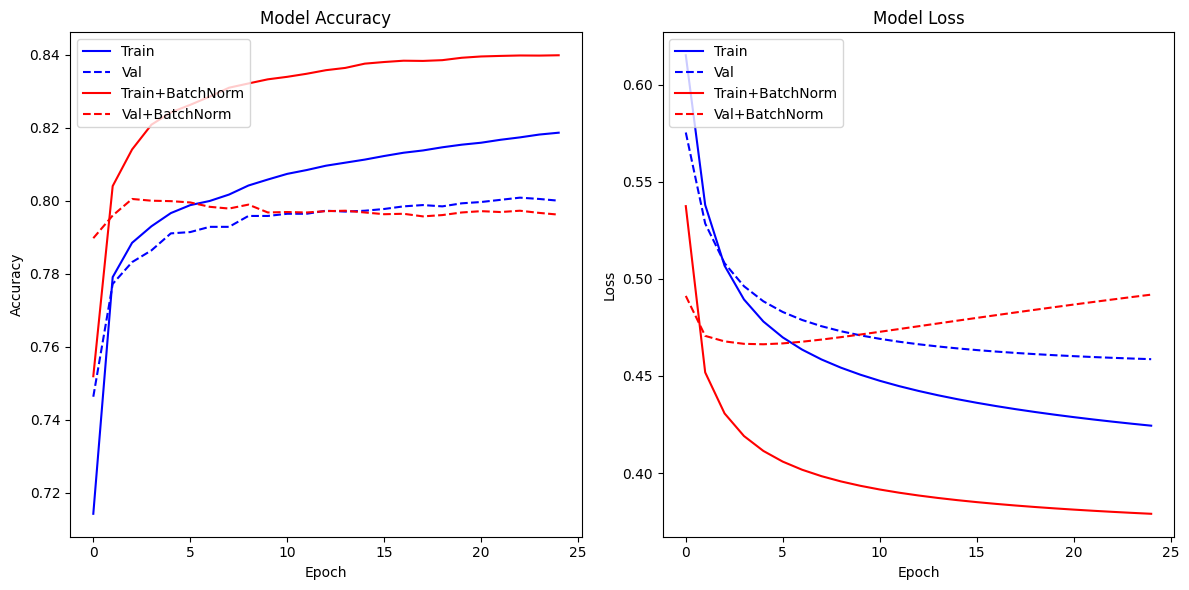

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = ['b', 'r']  # Colores para grupos
labels = ['Train', 'Val', 'Train+BatchNorm', 'Val+BatchNorm']
for i, history in enumerate([history_ffnn_initialization.history, history_ffnn_batchNorm.history]):
    plt.plot(history['accuracy'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_accuracy'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
for i, history in enumerate([history_ffnn_initialization.history, history_ffnn_batchNorm.history]):
    plt.plot(history['loss'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_loss'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Vemos como añadir Batch Normalization, a parte de mejorar los resultados: 
- Ayuda al modelo a converger más rápidamente durante el entrenamiento. Esto se aprecia en el rápido aumento de la precisión del entrenamiento y la rápida disminución de las pérdidas.
- Ayuda a reducir el sobreajuste, como demuestran la precisión de validación más estable y alta, y la pérdida de validación más controlada.

**Disclaimer**

La normalización por lotes no se suele utilizar con datos de texto por varias razones:

Los embeddings preentrenados como Word2Vec, GloVe o las de modelos lingüísticos como BERT y GPT ya están bien distribuidos y normalizados hasta cierto punto. Aplicar Batch Normalization a estos embeddings puede no aportar beneficios adicionales.

Una forma de mejorar el rendimiento del modelo es aumentar la complejidad de la red, es decir, añadir más capas y neuronas.

In [24]:
model_ffnn_batchNorm_adjusted = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=True),  # Hacer los embeddings entrenables
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),  # Primera capa Dense con activación ReLU
    BatchNormalization(),  # Normalización por lotes después de la activación
    Dense(64, kernel_initializer=GlorotUniform(), activation='relu'),  # Segunda capa Dense para mayor profundidad
    BatchNormalization(),  # Otra capa de normalización por lotes
    Dense(1, activation='sigmoid', kernel_initializer=GlorotUniform())  # Capa de salida con activación sigmoide
])

# Resumen de la arquitectura del modelo ajustado
model_ffnn_batchNorm_adjusted.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     2,122,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,400 (8.10 MB)

 Trainable params: 2,122,400 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Compilación del modelo
model_ffnn_batchNorm_adjusted.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Ejemplo de entrenamiento del modelo y guardado del historial
history_ffnn_batchNorm_adjusted = model_ffnn_batchNorm_adjusted.fit(X_train, y_train, epochs=25, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7091 - loss: 0.5896 - val_accuracy: 0.7467 - val_loss: 0.5128
Epoch 2/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8469 - loss: 0.3641 - val_accuracy: 0.8088 - val_loss: 0.4340
Epoch 3/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8895 - loss: 0.2899 - val_accuracy: 0.8224 - val_loss: 0.4142
Epoch 4/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9198 - loss: 0.2320 - val_accuracy: 0.8304 - val_loss: 0.4069
Epoch 5/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9436 - loss: 0.1838 - val_accuracy: 0.8322 - val_loss: 0.4058
Epoch 6/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9601 - loss: 0.1455 - val_accuracy: 0.8405 - val_loss: 0.4021
Epoch 7/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9720 - loss: 0.1150 - val_accuracy: 0.8431 - val_loss: 0.4052
Epoch 8/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9796 - loss: 0.0918 - val_accu

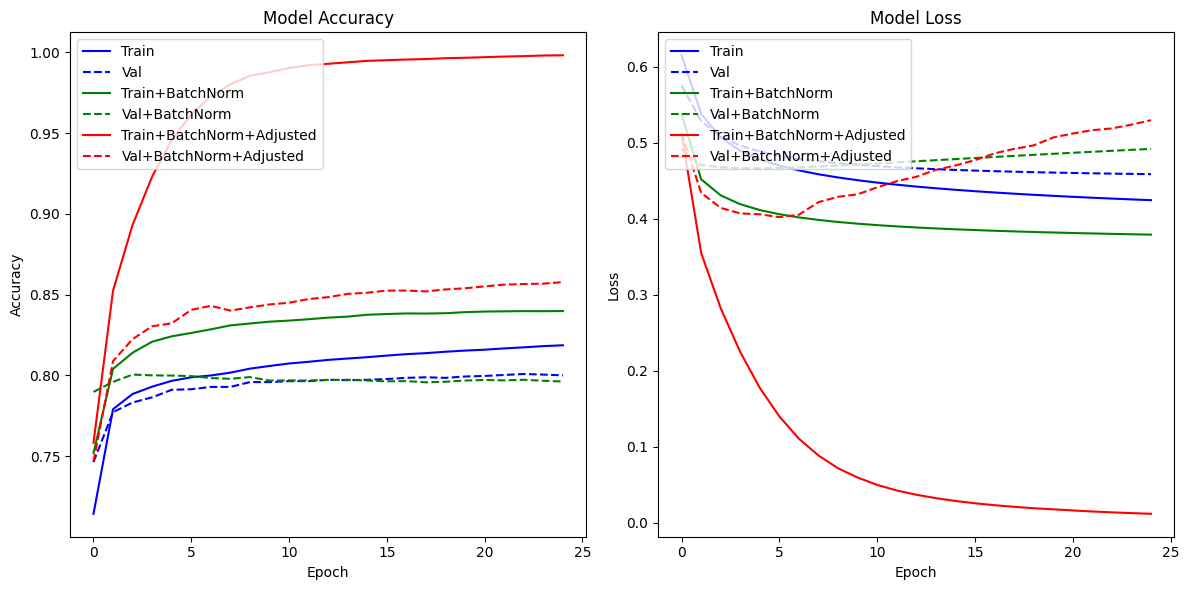

In [26]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = ['b', 'g', 'r']  # Colores para grupos
labels = ['Train', 'Val', 'Train+BatchNorm', 'Val+BatchNorm', 'Train+BatchNorm+Adjusted', 'Val+BatchNorm+Adjusted']
for i, history in enumerate([history_ffnn_initialization.history, history_ffnn_batchNorm.history, history_ffnn_batchNorm_adjusted.history]):
    plt.plot(history['accuracy'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_accuracy'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
for i, history in enumerate([history_ffnn_initialization.history, history_ffnn_batchNorm.history, history_ffnn_batchNorm_adjusted.history]):
    plt.plot(history['loss'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_loss'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#### 4.4.2 Dropout

Dropout es una técnica de regularización utilizada en el entrenamiento de redes neuronales para prevenir el sobreajuste. La idea detrás del dropout es simple pero efectiva: durante el entrenamiento, algunas de las neuronas de la red se "apagan" aleatoriamente, es decir, se ignoran temporalmente junto con todas sus conexiones. Esto significa que en cada paso de entrenamiento, una subred aleatoria de la red original recibe el gradiente y se actualiza. Como resultado, el proceso de entrenamiento simula entrenar una gran cantidad de redes neuronales pequeñas y diferentes.

Las principales ventajas de utilizar dropout son:

- **Reducir el Sobreajuste**: Al no permitir que la red dependa demasiado de cualquier conjunto de neuronas, dropout promueve la distribución del peso de aprendizaje a lo largo de la red, lo que puede mejorar la generalización.
- **Efecto de Ensamblaje**: Cada iteración entrena una subred diferente con una arquitectura aleatoria. La predicción final puede verse como el promedio de las predicciones de muchas subredes, similar a un modelo de ensamblaje.

Dropout se aplica típicamente a las capas completamente conectadas (Dense) de una red, aunque puede utilizarse en casi cualquier tipo de capas. La tasa de dropout, que es la fracción de neuronas que se desactivan, es un hiperparámetro que puede ajustarse para obtener el mejor rendimiento en el conjunto de validación.

In [27]:
# Definir el modelo con inicialización especificada en la capa Dense, agregar normalización por lotes y Dropout
model_ffnn_dropout_02 = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=True),  # Hacer los embeddings entrenables
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),  # Primera capa Dense con activación ReLU
    BatchNormalization(),  # Normalización por lotes después de la activación
    Dropout(0.2),  # Añadir Dropout para regularización
    Dense(64, kernel_initializer=GlorotUniform(), activation='relu'),  # Segunda capa Dense para mayor profundidad
    BatchNormalization(),  # Otra capa de normalización por lotes
    Dropout(0.2),  # Añadir otro Dropout
    Dense(1, activation='sigmoid')  # Capa de salida con activación sigmoide
])

# Definir el modelo con inicialización especificada en la capa Dense, agregar normalización por lotes y Dropout
model_ffnn_dropout_05 = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=True),  # Hacer los embeddings entrenables
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),  # Primera capa Dense con activación ReLU
    BatchNormalization(),  # Normalización por lotes después de la activación
    Dropout(0.5),  # Añadir Dropout para regularización
    Dense(64, kernel_initializer=GlorotUniform(), activation='relu'),  # Segunda capa Dense para mayor profundidad
    BatchNormalization(),  # Otra capa de normalización por lotes
    Dropout(0.5),  # Añadir otro Dropout
    Dense(1, activation='sigmoid')  # Capa de salida con activación sigmoide
])

In [28]:
# Compilar el modelo
model_ffnn_dropout_02.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
model_ffnn_dropout_05.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])


# Ejemplo de entrenamiento del modelo y guardado del historial
history_ffnn_dropout_02 = model_ffnn_dropout_02.fit(X_train, y_train, epochs=25, batch_size=128, validation_data=(X_val, y_val), verbose=0)
history_ffnn_dropout_05 = model_ffnn_dropout_05.fit(X_train, y_train, epochs=25, batch_size=128, validation_data=(X_val, y_val), verbose=0)

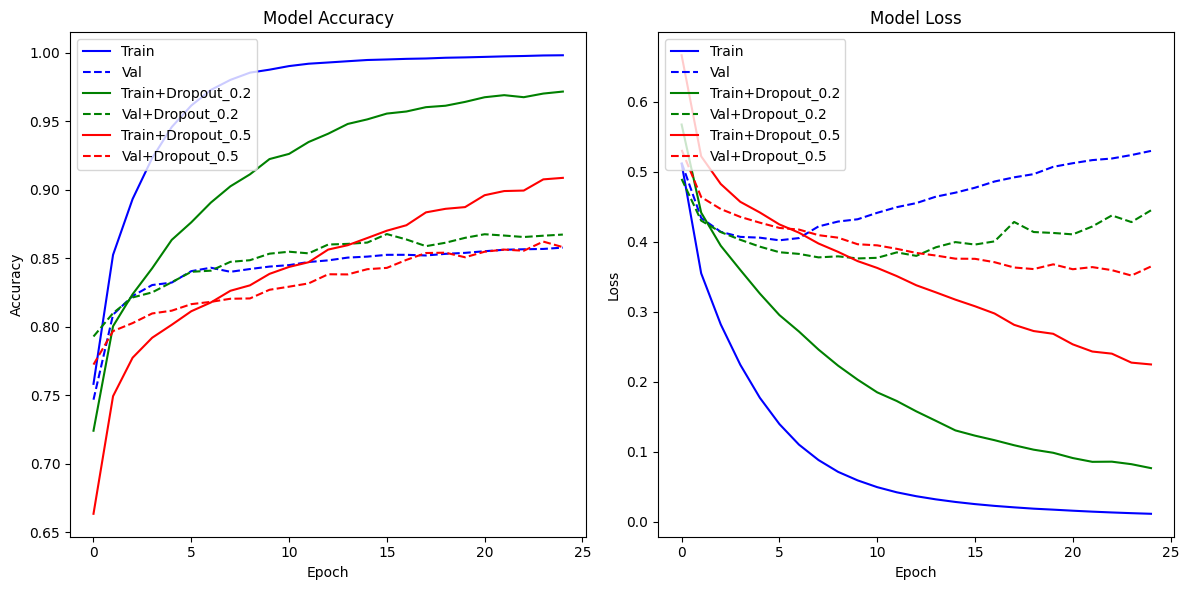

In [29]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = ['b', 'g', 'r']  # Colores para grupos
labels = ['Train', 'Val', 'Train+Dropout_0.2', 'Val+Dropout_0.2', 'Train+Dropout_0.5', 'Val+Dropout_0.5']
for i, history in enumerate([history_ffnn_batchNorm_adjusted.history, history_ffnn_dropout_02.history, history_ffnn_dropout_05.history]):
    plt.plot(history['accuracy'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_accuracy'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
for i, history in enumerate([history_ffnn_batchNorm_adjusted.history, history_ffnn_dropout_02.history, history_ffnn_dropout_05.history]):
    plt.plot(history['loss'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_loss'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Dropout no es tan efectivo en redes neuronales muy simples debido a su propia naturaleza y objetivo. Dropout está diseñado para reducir el sobreajuste al "apagar" aleatoriamente neuronas durante el entrenamiento, lo que ayuda a que la red se vuelva menos sensible a los datos de entrenamiento específicos. Sin embargo, en redes muy simples, con pocas neuronas o capas, el sobreajuste no es tan pronunciado porque la capacidad del modelo para aprender patrones complejos es limitada. Por lo tanto, aplicar dropout en este contexto podría no tener un impacto significativo o incluso podría ser contraproducente, limitando aún más la capacidad de aprendizaje del modelo.

#### 4.4.3 L1 y L2 y early stopping

Estas técnicas agregan un término de penalización al coste del modelo basados en los valores de los pesos. En el caso de L1 o Lasso, tiende a reducir el valor de los pesos hacia cero. L2 o Ridge, en cambio, fuerza a que los pesos sean pequeños, pero no haciéndolos exactamente cero. L1 es más robusto que L2, aunque L2 requiere menos recursos computacionales. L1 tiende a generar modelos más dispersos, mientras que L2 tiende a distribuir los pesos de manera más uniforme.

El early stopping es una técnica de regularización que se utiliza para evitar el sobreajuste. Consiste en detener el entrenamiento del modelo cuando el rendimiento del modelo en el conjunto de validación comienza a empeorar, es decir, cuando la pérdida en el conjunto de validación comienza a aumentar. El early stopping se basa en la intuición de que, si el rendimiento del modelo en el conjunto de validación comienza a empeorar, es probable que el modelo esté sobreajustando los datos de entrenamiento y, por lo tanto, no generalizará bien a datos no vistos.

In [30]:
# Definir el modelo con inicialización especificada en la capa Dense, agregar normalización por lotes, Dropout y regularización L1, L2
model_ffnn_l1_l2_early_stopping = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=True),  # Hacer los embeddings entrenables
    Flatten(),
    Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),  # Primera capa Dense con activación ReLU
    BatchNormalization(),  # Normalización por lotes después de la activación
    Dense(64, kernel_initializer=GlorotUniform(), activation='relu'),  # Segunda capa Dense para mayor profundidad
    BatchNormalization(),  # Otra capa de normalización por lotes
    Dense(1, activation='sigmoid', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))  # Capa de salida con regularización L1 y L2
])

# Printear la arquitectura del modelo
model_ffnn_l1_l2_early_stopping.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │     2,122,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,400 (8.10 MB)

 Trainable params: 2,122,400 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Compilar el modelo
model_ffnn_l1_l2_early_stopping.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Configurar el callback de Early Stopping para monitorear la 'val_loss' y detener el entrenamiento después de 5 épocas sin mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Asumiendo que tienes X_train, y_train, X_val, y_val, puedes entrenar el modelo con Early Stopping
history_ffnn_l1_l2_early_stopping = model_ffnn_l1_l2_early_stopping.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7090 - loss: 0.7091 - val_accuracy: 0.7919 - val_loss: 0.5935
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8472 - loss: 0.4657 - val_accuracy: 0.8150 - val_loss: 0.5141
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8795 - loss: 0.4033 - val_accuracy: 0.8255 - val_loss: 0.4911
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9017 - loss: 0.3612 - val_accuracy: 0.8352 - val_loss: 0.4789
Epoch 5/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9209 - loss: 0.3276 - val_accuracy: 0.8413 - val_loss: 0.4733
Epoch 6/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9378 - loss: 0.2991 - val_accuracy: 0.8466 - val_loss: 0.4693
Epoch 7/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9491 - loss: 0.2747 - val_accuracy: 0.8502 - val_loss: 0.4656
Epoch 8/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9592 - loss: 0.2534 - val_accu

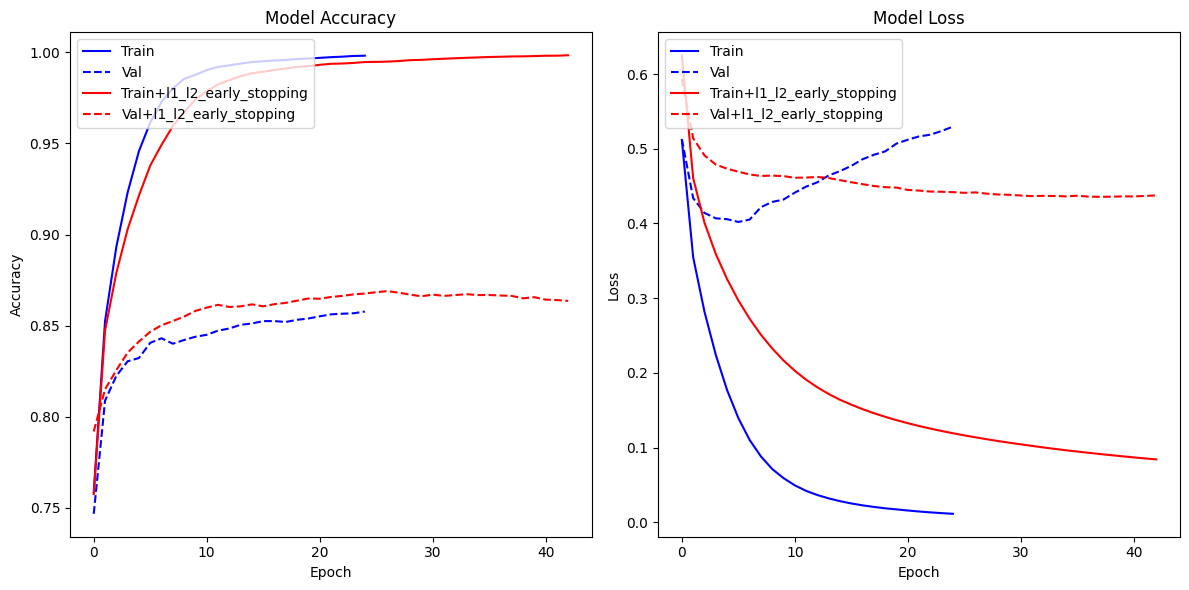

In [32]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = ['b', 'r']  # Colores para grupos
labels = ['Train', 'Val', 'Train+l1_l2_early_stopping', 'Val+l1_l2_early_stopping']
for i, history in enumerate([history_ffnn_batchNorm_adjusted.history, history_ffnn_l1_l2_early_stopping.history]):
    plt.plot(history['accuracy'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_accuracy'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
for i, history in enumerate([history_ffnn_batchNorm_adjusted.history, history_ffnn_l1_l2_early_stopping.history]):
    plt.plot(history['loss'], color=colors[i], label=labels[i*2])
    plt.plot(history['val_loss'], '--', color=colors[i], label=labels[i*2+1])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### 4.6 Optimización

En este apartado compararemos 4 optimizadores:
- **SGD** (Descenso de Gradiente Estocástico): Actualiza los parámetros del modelo usando gradientes de un solo ejemplo o un pequeño lote de ejemplos de entrenamiento.
- **Adam** (Estimación de Momento Adaptativo): Combina el momentum y tasas de aprendizaje adaptativas para una convergencia eficiente y rápida.
- **RMSprop** (Propagación de la Media Cuadrática Raíz): Ajusta las tasas de aprendizaje basándose en un promedio móvil de los gradientes cuadrados, eficaz para problemas no estacionarios.
- **Adagrad** (Algoritmo de Gradiente Adaptativo): Adapta las tasas de aprendizaje basándose en gradientes históricos, adecuado para datos dispersos y con importancia variable de características.

También añadiremos learning rate decay. El learning rate decay es una técnica que consiste en reducir el learning rate a medida que el entrenamiento avanza. La idea detrás de esta técnica es que, a medida que el entrenamiento avanza, el modelo se acerca al mínimo global y, por lo tanto, el learning rate debe reducirse para evitar oscilaciones alrededor del mínimo global.

In [33]:
def lr_schedule(epoch, lr):
    """Función de decaimiento de la tasa de aprendizaje que puedes ajustar según tus necesidades."""
    if epoch > 10:
        lr = lr * np.exp(-0.1)
    return lr

optimizers = {
    'SGD': SGD(learning_rate=0.01),
    'RMSprop': RMSprop(learning_rate=0.001),
    'Adagrad': Adagrad(learning_rate=0.01),
    'Adam': Adam(learning_rate=0.001),
}

histories = {}

for name, optimizer in optimizers.items():
    print(f"Entrenando con el optimizador: {name}")
    model_ffnn_optimizer = Sequential([
        Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding_matrix], input_length=100, trainable=True),  # Hacer los embeddings entrenables
        Flatten(),
        Dense(128, kernel_initializer=GlorotUniform(), activation='relu'),  # Primera capa Dense con activación ReLU
        BatchNormalization(),  # Normalización por lotes después de la activación
        Dense(64, kernel_initializer=GlorotUniform(), activation='relu'),  # Segunda capa Dense para mayor profundidad
        BatchNormalization(),  # Otra capa de normalización por lotes
        Dense(1, activation='sigmoid', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))  # Capa de salida con regularización L1 y L2
    ])
    
    # Compilar el modelo con el optimizador actual
    model_ffnn_optimizer.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Configurar el callback de Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
    lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)
    
    # Entrenar el modelo y guardar el historial
    history = model_ffnn_optimizer.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping, lr_scheduler])
    histories[name] = history

# Ahora `histories` contiene los historiales de entrenamiento para cada optimizador

Entrenando con el optimizador: SGD

Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.7154 - loss: 0.7180 - val_accuracy: 0.7944 - val_loss: 0.5857 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8413 - loss: 0.4727 - val_accuracy: 0.8148 - val_loss: 0.5195 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8769 - loss: 0.4085 - val_accuracy: 0.8218 - val_loss: 0.5009 - learning_rate: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/50
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8976 - loss: 0.3673 - val_accuracy: 0.8293 - val_loss: 0.4878 - learning_rate: 0.0100

Epoch 5: LearningRateScheduler setti

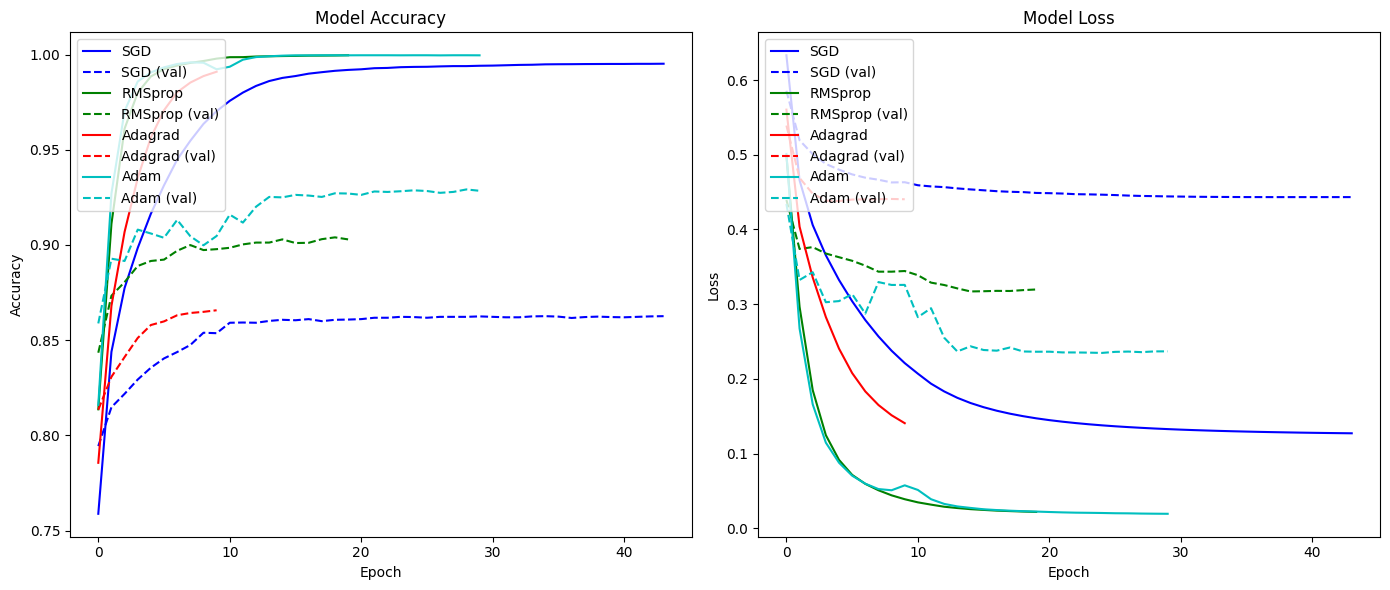

In [34]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

# Gráfica de precisión
plt.subplot(1, 2, 1)
colors = ['b', 'g', 'r', 'c']  # Colores para grupos
for i, (name, history) in enumerate(histories.items()):
    plt.plot(history.history['accuracy'], color=colors[i], label=f'{name}')
    plt.plot(history.history['val_accuracy'], '--', color=colors[i], label=f'{name} (val)')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Gráfica de pérdida
plt.subplot(1, 2, 2)
for i, (name, history) in enumerate(histories.items()):
    plt.plot(history.history['loss'], color=colors[i], label=f'{name}')
    plt.plot(history.history['val_loss'], '--', color=colors[i], label=f'{name} (val)')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 5. Evaluación del modelo

En este apartado evaluaremos el modelo con los hiperparámetros optimizados sobre el conjunto de test.

In [35]:
# Filtrar el dataset para que solo contenga las clases 'Positive' y 'Negative'
df_test = df_test[df_test['label'].isin(['Positive', 'Negative'])]

# Preparamos los datos de test
sequences_test = tokenizer.texts_to_sequences(df_test['text_clean'].values)
X_test = pad_sequences(sequences_test, maxlen=100)
X_test = X_test.astype('float32')
y_test = df_test['label'].map({'Positive': 1, 'Negative': 0}).values.astype('float32')

In [36]:
# Evaluamos el modelo ffnn en los datos de test
loss_ffnn, accuracy_ffnn = model_ffnn.evaluate(X_test, y_test)

# Evaluamos el modelo ffnn_best en los datos de test
loss_ffnn_best, accuracy_ffnn_best = model_ffnn_optimizer.evaluate(X_test, y_test)

print(f"Accuracy of model_ffnn: {accuracy_ffnn}")
print(f"Accuracy of model_ffnn_best: {accuracy_ffnn_best}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8175 - loss: 0.4064  
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9713 - loss: 0.1063  
Accuracy of model_ffnn: 0.8450184464454651
Accuracy of model_ffnn_best: 0.9815497994422913


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


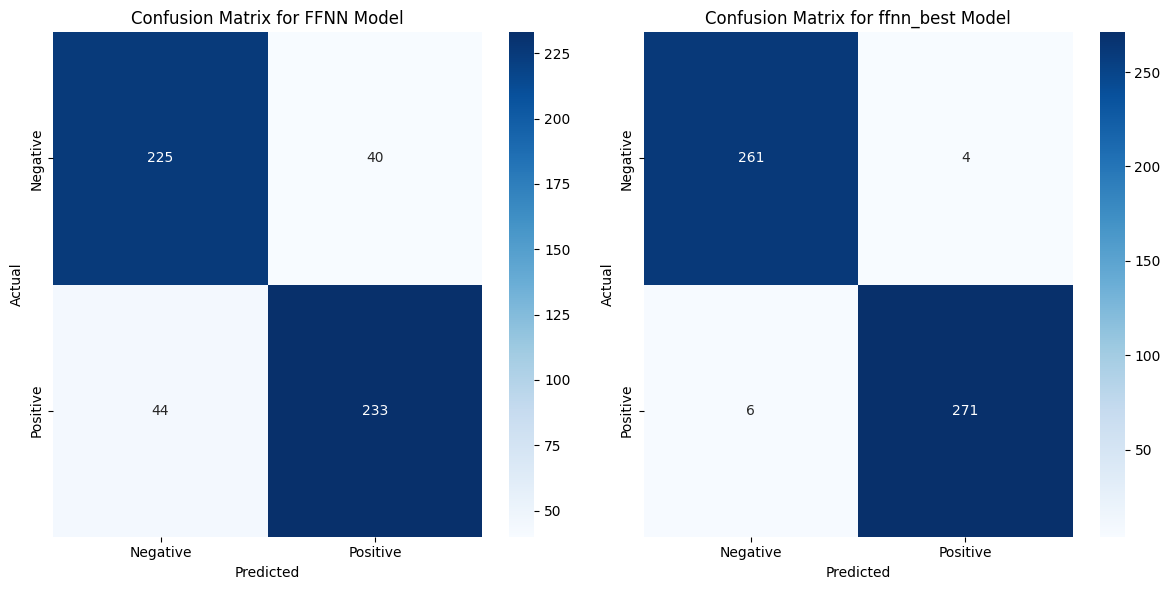

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predictions for model_ffnn
y_pred_ffnn = model_ffnn.predict(X_test)
y_pred_ffnn = (y_pred_ffnn > 0.5).astype(int)

# Get the predictions for model_ffnn_best
y_pred_ffnn_best = model_ffnn_optimizer.predict(X_test)
y_pred_ffnn_best = (y_pred_ffnn_best > 0.5).astype(int)

# Compute the confusion matrix for model_ffnn
cm_ffnn = confusion_matrix(y_test, y_pred_ffnn)

# Compute the confusion matrix for model_ffnn_best
cm_ffnn_best = confusion_matrix(y_test, y_pred_ffnn_best)

# Plot both confusion matrices side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_ffnn, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for FFNN Model')

plt.subplot(1, 2, 2)
sns.heatmap(cm_ffnn_best, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for ffnn_best Model')

plt.tight_layout()

# Qué hemos aprendido hoy?

- Sesgo y varianza
- Definición de Hiperparámetros
- Hiperparámetros básicos
    - batch size
- Hiperparámetos avanzados
    - Inicialización
    - Regularización
    - Optimización
- Comparación de resultados